In [ ]:
import datetime
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import xarray as xr
## optional for land mask
from global_land_mask import globe
from statsmodels.tsa.stattools import adfuller

In [21]:
t2m = xr.open_dataset('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjfm_era5_t2m_40to23Apr.nc')
t2m = t2m.rename({'longitude':'lon', 'latitude':'lat'})
t2m = t2m-273

In [ ]:
## Should I set to same time period as in jet core?
t2m = t2m.sel(time=slice("1940", "2023"))

## my way of getting anomalies

In [ ]:
t2m['t2m'].sel(time=t2m['time'].dt.month.isin([12])).std(('lat', 'lon'))

In [ ]:
# Align the climatological mean to the original dataset
aligned_clim_mean = t2m['t2m'].groupby('time.dayofyear').mean().sel(dayofyear=t2m['time.dayofyear'])

In [ ]:
def get_linear_reg_slope(data, col_name):
    lin_reg_data = prepare_data_for_linear_reg(data, col_name)
    return linear_reg_slope(lin_reg_data)


def prepare_data_for_linear_reg(data, col_name):
    values = data[col_name].values.astype(float)
    ordinal_dates = get_ordinal_dates(data)
    lin_reg_data = pd.DataFrame([values, ordinal_dates]).T
    lin_reg_data = lin_reg_data.dropna()
    return lin_reg_data


def get_ordinal_dates(data, index_col_name='time'):
    return pd.to_datetime(data.reset_index()[index_col_name]).apply(lambda date: date.toordinal())


def linear_reg_slope(data):
    """
        data[0] should be values, data[1] should be ordinal dates
    """
    slope, intercept = np.polyfit(data[1], data[0], 1)
    lr1d = np.poly1d([slope, intercept])(data[1])
    return pd.DataFrame(lr1d, index=data[1].apply(lambda row: pd.to_datetime(datetime.date.fromordinal(int(row)))), columns=['reg_line'])

In [ ]:
t2m_stacked = t2m.stack(paired_points=['lat','lon'])

In [ ]:
def slope_per_year(x):
    sl = scipy.stats.linregress(x.time.astype(float),x[dict(paired_points=0)]).slope   
    
    # Determine the time step in your dataset (e.g., months, days)
    time_step = (x.time[1] - x.time[0]).astype('timedelta64[D]').astype(int)  # Example for daily data

    # Convert the slope coefficient into trend per year
    trend_da_per_year = sl * time_step #/ 365.25  # Adjust for leap years if necessary

    return xr.DataArray(trend_da_per_year)

<xarray.DataArray 'time' (paired_points: 32760)> Size: 262kB
array([2.29800687e-04, 2.29800687e-04, 2.29800687e-04, ...,
       2.70790803e-05, 2.75123976e-05, 2.73405211e-05])
Coordinates:
  * paired_points  (paired_points) object 262kB MultiIndex
  * lat            (paired_points) float64 262kB 90.0 90.0 90.0 ... 0.0 0.0 0.0
  * lon            (paired_points) float64 262kB 0.0 1.0 2.0 ... 358.0 359.0

In [ ]:
%%time
t2m_grouped = t2m_stacked['t2m'].groupby('paired_points').apply(slope_per_year)

In [ ]:
t2m_grouped

In [ ]:
unstack = t2m_grouped.unstack('paired_points')

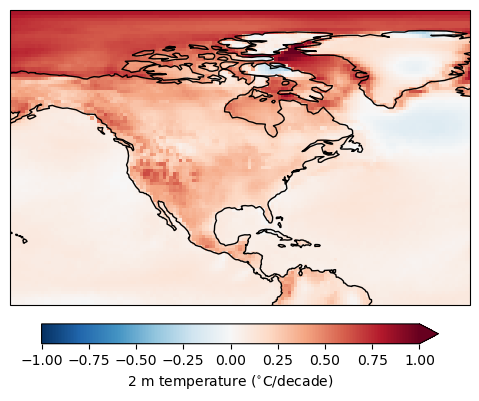

In [24]:
fig, ax = plt.subplots(1, subplot_kw={'projection':ccrs.PlateCarree()})
(unstack*365.25*10).sel(lon=slice(200, 340)).plot(center=0, vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'shrink':.8, 'pad':.05, 'orientation':'horizontal', 'label':'2 m temperature ($^{\circ}$C/decade)'})
ax.coastlines()
ax.set_extent([-160, -20, 0, 90])
# fig.savefig("figures/t2m_trend_decade.png", dpi=200, bbox_inches='tight')

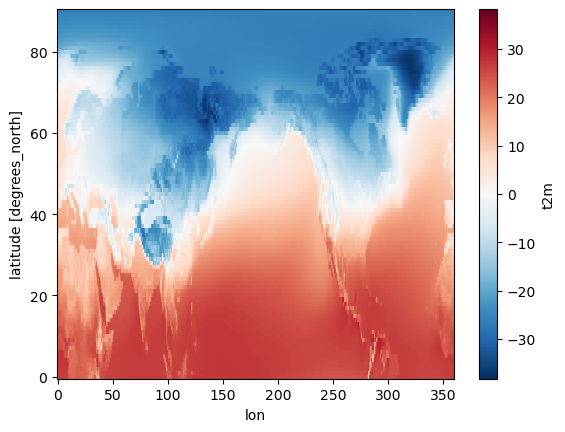

In [25]:
aligned_clim_mean.mean('time').plot()

In [ ]:
%%time
rolling_temp_anom = t2m['t2m'] - aligned_clim_mean

In [27]:
%%time
rolling_temp_anom = rolling_temp_anom.dropna('time')

CPU times: user 4.01 s, sys: 6.09 s, total: 10.1 s
Wall time: 17 s


In [32]:
if os.path.exists('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_t2m_40to23Apr_detrended.nc'):
    print('load data')
    rolling_temp_anom = rolling_temp_anom.to_dataset()
    rolling_temp_anom['t2m_detrended'] = xr.open_dataset('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_t2m_40to23Apr_detrended.nc')['t2m_detrended']
else:
    print('making data')
    detrended_rolling_temp_anom = scipy.signal.detrend(rolling_temp_anom, type='linear')
    detrended_rolling_temp_anom_da = xr.DataArray(detrended_rolling_temp_anom, dims=('time', 'lat', 'lon'))
    rolling_temp_anom = rolling_temp_anom.to_dataset()
    rolling_temp_anom['t2m_detrended'] = detrended_rolling_temp_anom_da
    rolling_temp_anom['t2m_detrended'].to_netcdf('/home/thomaskeel/Dev/Climate_Data/ERA-5/ndjm_era5_t2m_40to23Apr_detrended.nc')

load data


In [17]:
NAm_t2m = rolling_temp_anom['t2m_detrended'].sel(lat=slice(70, 20), lon=slice(230, 320), time=slice(None, None)).mean(("lat", "lon"))

In [18]:
adfuller(NAm_t2m)

(-22.021966235299693,
 0.0,
 35,
 30399,
 {'1%': -3.4305651337963474,
  '5%': -2.8616350833686712,
  '10%': -2.5668206099675763},
 -2618.7667074378187)

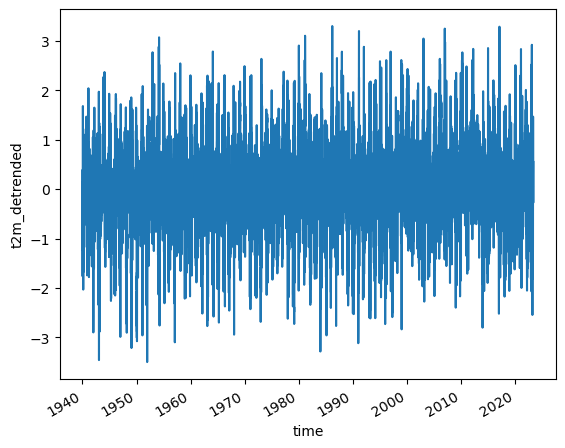

In [19]:
NAm_t2m.plot()

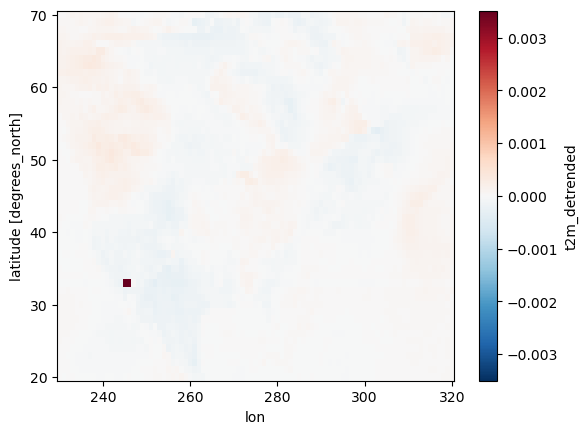

In [20]:
rolling_temp_anom['t2m_detrended'].sel(lat=slice(70, 20), lon=slice(230, 320), time=slice(None, None)).mean("time").plot()

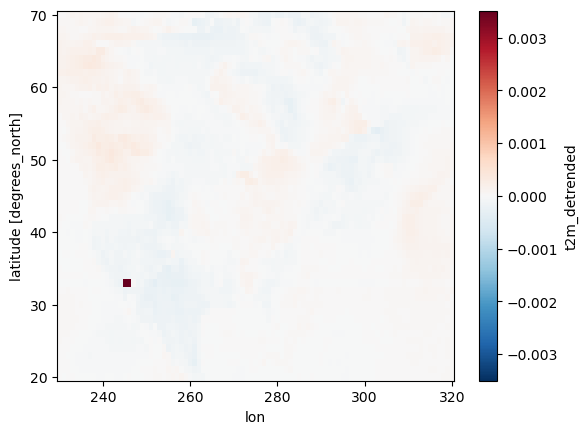

In [21]:
rolling_temp_anom['t2m_detrended'].sel(lat=slice(70, 20), lon=slice(230, 320), time=slice(None, None)).mean("time").plot()

In [22]:
global_rolling_temp_anom = rolling_temp_anom['t2m_detrended'].mean(('lat', 'lon'))

In [23]:
adfuller(global_rolling_temp_anom.dropna(dim='time'))

(-8.726619656782335,
 3.275446757836053e-14,
 49,
 30385,
 {'1%': -3.4305652329284078,
  '5%': -2.8616351271807945,
  '10%': -2.5668206332877053},
 -959149.5602648865)

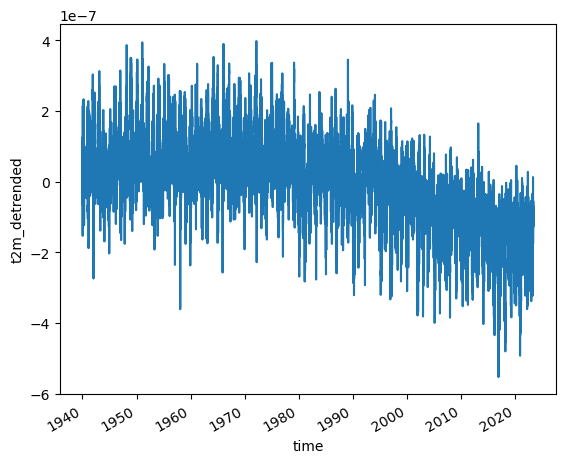

In [24]:
global_rolling_temp_anom.plot()

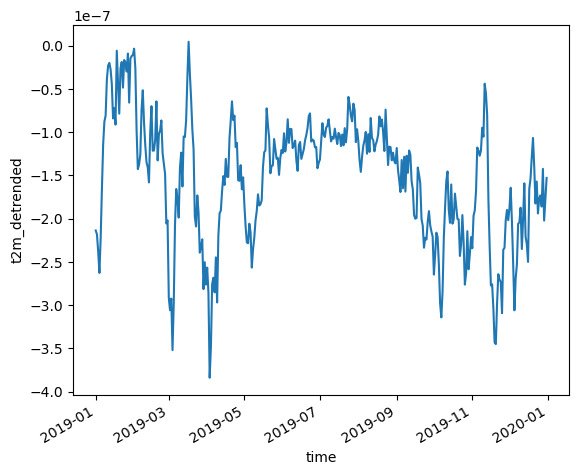

In [25]:
global_rolling_temp_anom.sel(time="2019").plot()

In [26]:
# all_extreme_low_days = (rolling_temp_anom < t2m_month_anom_upperlower_quantile.isel(quantile=0))

In [27]:
# t2m_month_anom.sel(lon=10, lat=60, time=slice("2022-01", "2022-01"))

<Axes: ylabel='Density'>

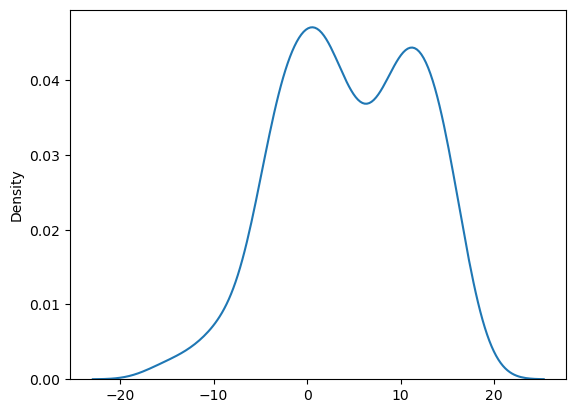

In [28]:
sns.kdeplot(t2m.sel(lon=10, lat=60, time=slice("2022", "2022"))['t2m'])

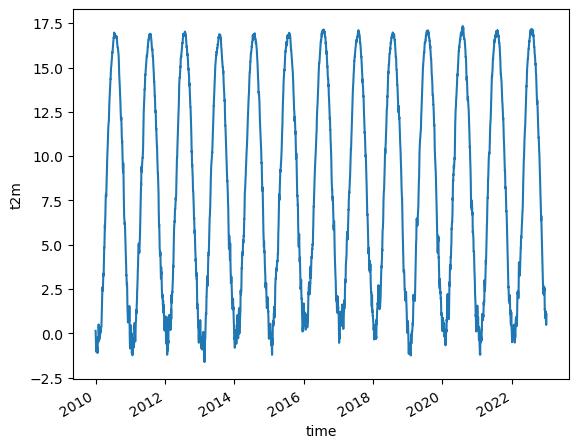

In [29]:
t2m.mean(('lat', 'lon')).sel(time=slice("2010", "2022"))['t2m'].plot()

In [30]:
# %%time
month_mean_temp = t2m['t2m'].groupby(t2m['time'].dt.month).mean()

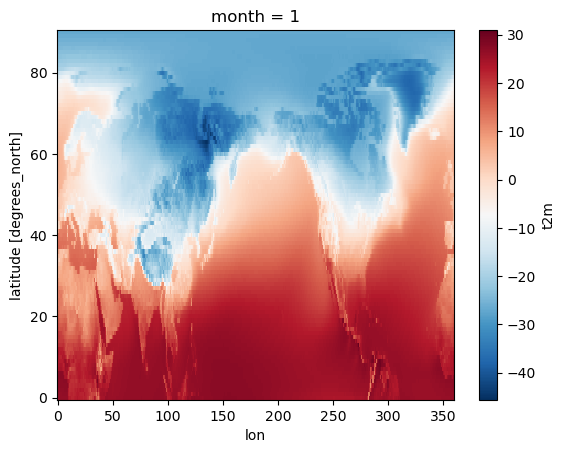

In [31]:
month_to_examine = 0
(month_mean_temp.isel(month=month_to_examine)).plot(vmin=month_mean_temp.isel(month=month_to_examine).min()-.1, vmax=month_mean_temp.isel(month=month_to_examine).max()+.1, cmap='RdBu_r')

In [32]:
%%time
# t2m_month_anom = rolling_temp_anom['t2m_detrended'].groupby(rolling_temp_anom['t2m_detrended'].dt.month).apply(lambda x: x - month_mean_temp.sel(month=x['time'].dt.month[0]))

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.96 μs


In [33]:
%%time
## Takes 13 seconds
upper = 0.97
lower = 0.01
t2m_month_anom_upperlower_quantile = rolling_temp_anom['t2m_detrended'].quantile(q=[lower, upper], dim='time', method='linear')

CPU times: user 15.9 s, sys: 6.3 ms, total: 15.9 s
Wall time: 15.9 s


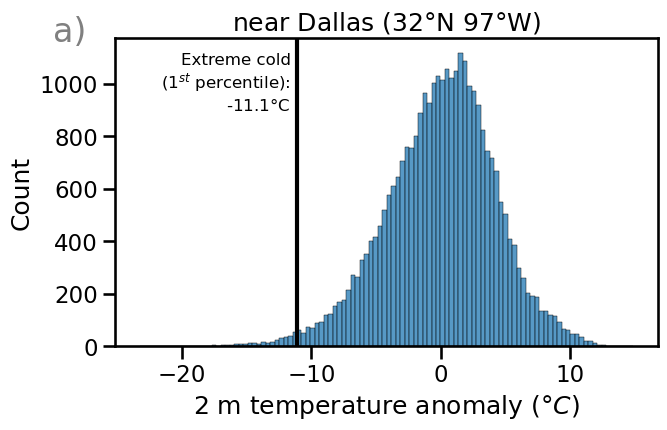

In [64]:
sns.set_context('talk')
lnd_anom = t2m_month_anom_upperlower_quantile.sel(lat=32, lon=264)[0]
fig, ax = plt.subplots(1, figsize=(7, 4))
sns.histplot(rolling_temp_anom['t2m_detrended'].sel(lat=32, lon=264), color='C0')
plt.title(r"near Dallas (32$\degree$N 97$\degree$W)")
plt.axvline(lnd_anom, 0, 1, linewidth=3, color='k')
plt.xlabel("2 m temperature anomaly ($\degree C$)")
text_1st_pnt = r'$1^{st}$' + ' percentile'
plt.text(s="a)", x=-30, y=1160, size=24, c='grey')
plt.text(s=f"Extreme cold\n({text_1st_pnt}):\n {lnd_anom: .1f}" + r"${\degree}$C", size=12, x=-11.6, y=900, ha='right')
# plt.savefig("figures/temp_hist_1perc_dallas.png", bbox_inches='tight', dpi=300)

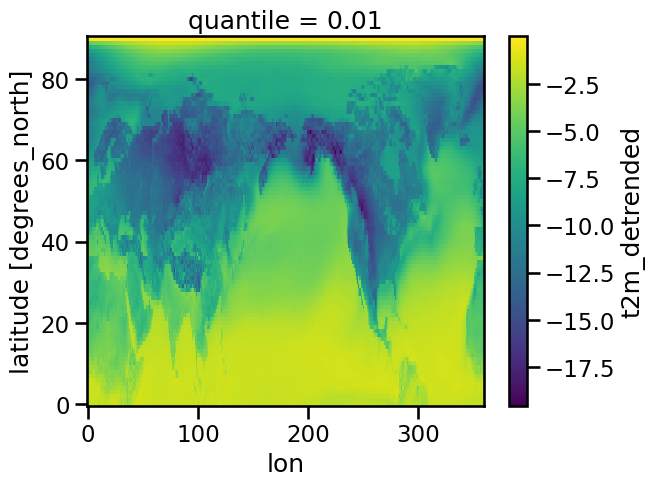

In [35]:
t2m_month_anom_upperlower_quantile.isel(quantile=0).plot()

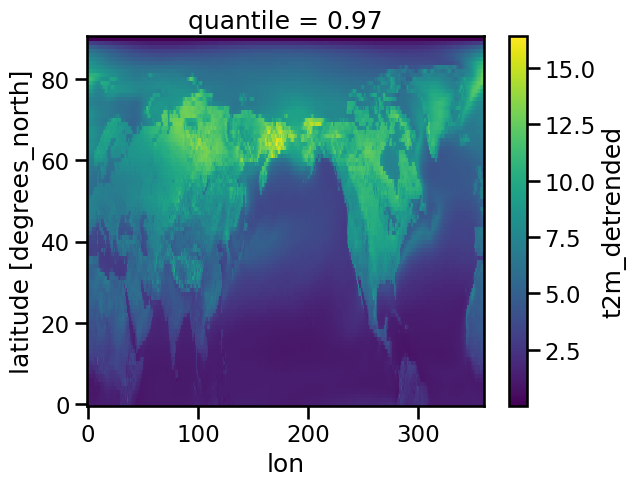

In [36]:
t2m_month_anom_upperlower_quantile.isel(quantile=-1).plot()

In [37]:
# (t2m['t2m'].sel(time="2021-02-12") - month_mean_temp.sel(month=2)).plot()

In [38]:
# fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
# region_to_examine = {'lon':slice(0, 360), 'lat': slice(90, 0)}
date_to_examine = "2021-02-16"
# month = int(date_to_examine[5:7])

# temp_day_day = t2m['t2m'].sel(time=date_to_examine).sel(region_to_examine)
# month_mean_day = month_mean_temp.sel(month=month).sel(region_to_examine)
# month_anom_day = t2m_month_anom.sel(time=date_to_examine).sel(region_to_examine)
# rolling_anom_day = rolling_temp_anom['t2m_detrended'].sel(time=date_to_examine).sel(region_to_examine)

# temp_day_day.plot(ax=axes[0][0], cmap='RdBu_r', vmin=temp_day_day.min(), vmax=temp_day_day.max())
# month_mean_day.plot(ax=axes[0][1], cmap='RdBu_r', vmin=month_mean_day.min(), vmax=month_mean_day.max())
# month_anom_day.plot(ax=axes[1][0], cmap='RdBu_r', vmin=month_anom_day.min(), vmax=month_anom_day.max())
# rolling_anom_day.plot.contourf(ax=axes[1][1], cmap='RdBu_r', vmin=rolling_anom_day.min(), vmax=rolling_anom_day.max())

                                                                     

In [39]:
# t2m_month_anom_upperlower_quantile.isel(quantile=-1) < rolling_temp_anom.sel(time=date_to_examine)

In [40]:
# (rolling_temp_anom['t2m_detrended'].sel(time=date_to_examine) > t2m_month_anom_upperlower_quantile.isel(quantile=-1)).plot()

In [41]:
# (rolling_temp_anom['t2m_detrended'].sel(time=date_to_examine) < t2m_month_anom_upperlower_quantile.isel(quantile=0)).plot()

# compare with jet core

In [42]:
kuang = xr.open_mfdataset('../../jet_feature_indices/data/era5_*_kuang_1200_5dayresample.nc')

In [43]:
extreme_day = kuang['jet_ocurrence1_jet_centre2'].sel(time=date_to_examine)

In [44]:
extreme_day = (extreme_day / extreme_day)

/home/thomaskeel/miniconda3/envs/jsanalysis/lib/python3.11/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


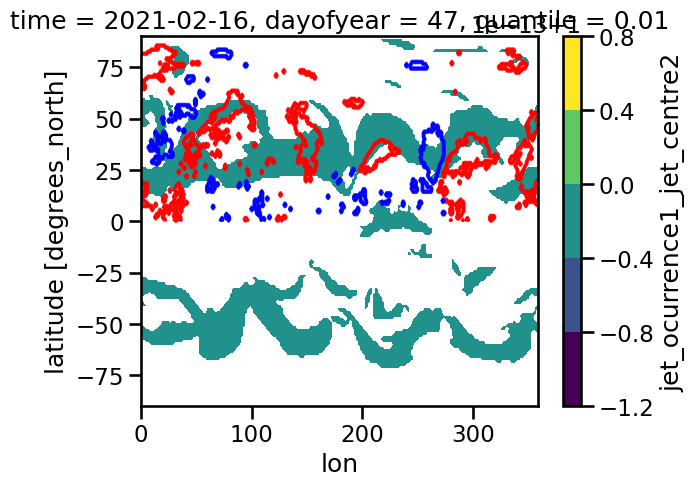

In [45]:
extreme_day.isel(time=0).plot.contourf()
(rolling_temp_anom['t2m_detrended'].sel(time=date_to_examine) > t2m_month_anom_upperlower_quantile.isel(quantile=-1)).plot.contour(cmap='red', alpha=.6)
(rolling_temp_anom['t2m_detrended'].sel(time=date_to_examine) < t2m_month_anom_upperlower_quantile.isel(quantile=0)).plot.contour(cmap='blue', alpha=.6)

In [46]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
# region_to_examine = {'lon':slice(0, 360), 'lat': slice(90, 0)}
# date_to_examine = "2021-02-16"

# month = int(date_to_examine[5:7])

# temp_day_day = t2m['t2m'].sel(time=date_to_examine).sel(region_to_examine)
# month_mean_day = month_mean_temp.sel(month=month).sel(region_to_examine)
# month_anom_day = t2m_month_anom.sel(time=date_to_examine).sel(region_to_examine)
# rolling_anom_day = rolling_temp_anom['t2m_detrended'].sel(time=date_to_examine).sel(region_to_examine)

# temp_day_day.plot(ax=axes[0][0], cmap='RdBu_r', vmin=temp_day_day.min(), vmax=temp_day_day.max())
# month_mean_day.plot(ax=axes[0][1], cmap='RdBu_r', vmin=month_mean_day.min(), vmax=month_mean_day.max())
# month_anom_day.plot(ax=axes[1][0], cmap='RdBu_r', vmin=month_anom_day.min(), vmax=month_anom_day.max())
# # rolling_anom_day.plot.contourf(ax=axes[1][1], cmap='RdBu_r', vmin=rolling_anom_day.min(), vmax=rolling_anom_day.max())
# # plt.show()

# date_to_examine_jet = date_to_examine
# extreme_day = kuang['jet_ocurrence1_jet_centre2'].sel(time=date_to_examine_jet)
# extreme_day = (extreme_day / extreme_day)
# extreme_day.isel(time=0).plot.contourf(ax=axes[1][1])

# temp_extreme_high =  (rolling_temp_anom['t2m_detrended'].sel(region_to_examine).sel(time=date_to_examine) > t2m_month_anom_upperlower_quantile.isel(quantile=-1))  &  (abs(month_anom_day) > 5)
# temp_extreme_low = (rolling_temp_anom['t2m_detrended'].sel(region_to_examine).sel(time=date_to_examine) < t2m_month_anom_upperlower_quantile.isel(quantile=0)) &  (abs(month_anom_day) > 5)
# temp_extreme_high.plot.contour(ax=axes[1][1], cmap='red', alpha=.6)
# temp_extreme_low.plot.contour(ax=axes[1][1], cmap='blue', alpha=.6)
# plt.show()

In [47]:
%%time
# all_extreme_high_days = (rolling_temp_anom > t2m_month_anom_upperlower_quantile.isel(quantile=-1))
all_extreme_low_days = (rolling_temp_anom['t2m_detrended'] < t2m_month_anom_upperlower_quantile.isel(quantile=0))

CPU times: user 1.18 s, sys: 78.3 ms, total: 1.26 s
Wall time: 1.25 s


### Plot Dallas extreme cold temperatures

In [48]:
# DALLAS is 32.78560340316631, -96.79343284302689

In [49]:
q05_houston = t2m_month_anom_upperlower_quantile.isel(quantile=0).sel(lat=32, lon=263)

In [50]:
print(float(q05_houston))

-11.868560447692872


In [51]:
rolling_temp_anom['t2m_detrended'].where(all_extreme_low_days, 0).sel(lat=32, lon=263)

<xarray.DataArray 't2m_detrended' (time: 30435)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    lon        float32 263.0
    lat        float32 32.0
  * time       (time) datetime64[ns] 1940-01-01 1940-01-02 ... 2023-04-30
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119 120
    quantile   float64 0.01

In [52]:
troughs, _ = scipy.signal.find_peaks(-rolling_temp_anom['t2m_detrended'].where(all_extreme_low_days, 0).sel(lat=32, lon=263), height=float(q05_houston))  # Peaks above 1.9

In [53]:
# Extract data as NumPy arrays
x = rolling_temp_anom['time'].astype(float).data
y = rolling_temp_anom['t2m'].sel(lat=32, lon=263).data
# Calculate the coefficients of the linear regression line
coefficients = np.polyfit(x, y, 1)
# Generate the regression line using the coefficients
regression_line = np.polyval(coefficients, x)

In [54]:
len(troughs)

206

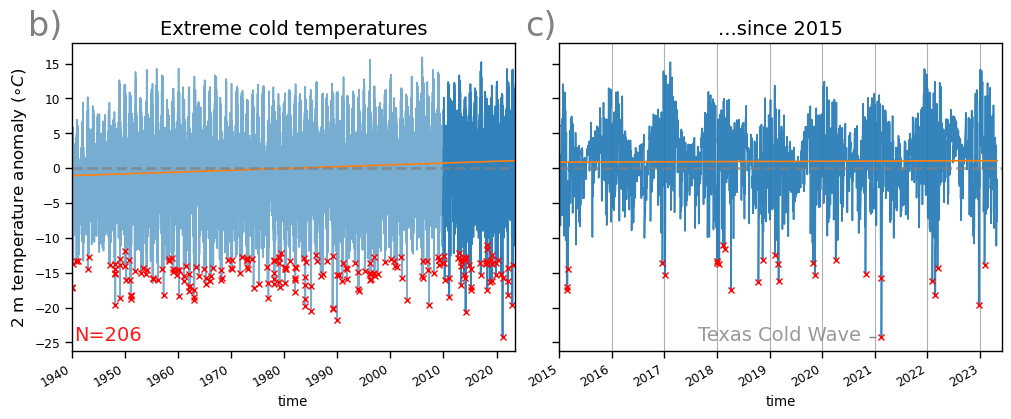

In [68]:
sns.set_context('paper')
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=True)
rolling_temp_anom['t2m'].sel(lat=32, lon=263).plot(ax=axes[0], alpha=.6)
rolling_temp_anom['t2m'].sel(lat=32, lon=263, time=slice("2010", None)).plot(ax=axes[0], c='C0', alpha=.8)
axes[0].plot(rolling_temp_anom['time'], regression_line)
axes[0].plot(rolling_temp_anom['time'][troughs], rolling_temp_anom['t2m'].sel(lat=32, lon=263)[troughs], 'rx', label='Peaks')
axes[0].hlines(0, datetime.date(1940, 1, 1), datetime.date(2023, 6, 1), linestyle='--', linewidth=2, color='grey', alpha=.7)
axes[0].set_title("Extreme cold temperatures", size=14)
axes[0].set_xlim([datetime.date(1940, 1, 1), datetime.date(2023, 6, 1)])
axes[0].set_ylabel("2 m temperature anomaly ($\circ C$)", size=12)
axes[0].text(s=f'N={len(troughs)}', x=datetime.date(1940, 6, 1), y=-24.75, color='r', alpha=.9, size=14)

rolling_temp_anom['t2m'].sel(lat=32, lon=263).plot(ax=axes[1], alpha=.9)
axes[1].plot(rolling_temp_anom['time'], regression_line)
axes[1].plot(rolling_temp_anom['time'][troughs], rolling_temp_anom['t2m'].sel(lat=32, lon=263)[troughs], 'rx', label='Peaks')
axes[1].hlines(0, datetime.date(1940, 1, 1), datetime.date(2023, 6, 1), linestyle='--', linewidth=2, color='grey', alpha=.7)
axes[1].set_title("...since 2015", size=14)
axes[1].set_xlim([datetime.date(2015, 1, 1), datetime.date(2023, 6, 1)])
# axes[1].arrow(x=datetime.date(2021, 9, 16), y=-3.9, dx=-90, dy=0.5, color='grey')
# Plot the rectangle
# texascoldwave_rectangle = plt.Rectangle((mdates.date2num(datetime.date(2021, 2, 2)), -26.9), 20, .25, edgecolor='grey', facecolor='grey', alpha=.8)
# axes[1].add_patch(texascoldwave_rectangle)
axes[1].text(s="Texas Cold Wave", x=datetime.date(2017, 8, 20), y=-24.8, color='grey', alpha=.8, size=14)
axes[1].hlines(-24.25, datetime.date(2020, 11, 20), datetime.date(2021, 1, 10), color='grey', linewidth=1)
axes[1].set_ylabel("")
axes[0].text(s="b)", x=-14000, y=19, size=24, c='grey')
axes[1].text(s="c)", x=16200, y=19, size=24, c='grey')
axes[1].grid(axis='x')

fig.subplots_adjust(wspace=.1)
# fig.savefig("figures/dallas_t2m_coldairevent_with_detrend.png", dpi=300, bbox_inches='tight')

In [56]:
%%time
TEMP_MIN = 20
all_extreme_low_days_temp_limit = all_extreme_low_days & (t2m['t2m'] < TEMP_MIN)

CPU times: user 664 ms, sys: 3.4 s, total: 4.06 s
Wall time: 4.06 s


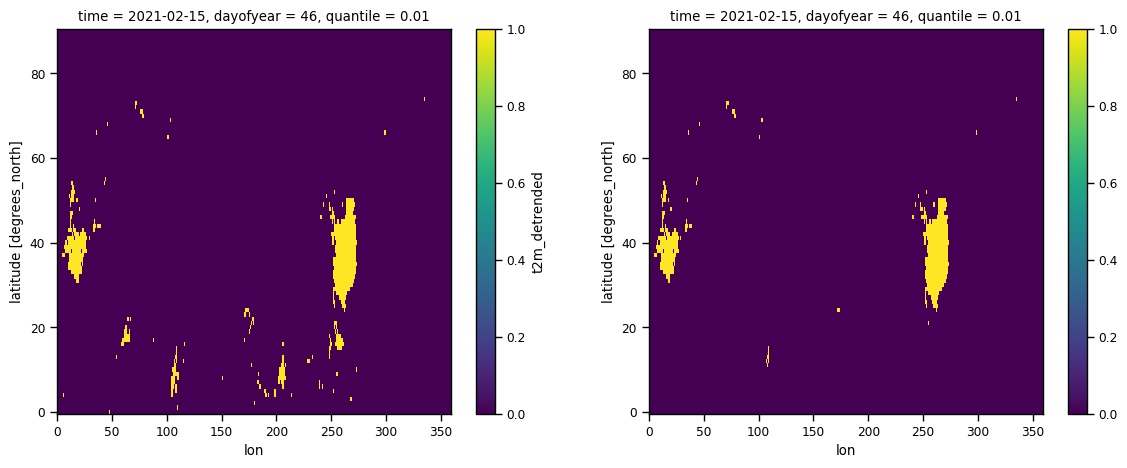

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
all_extreme_low_days.sel(time="2021-02-15").plot(ax=axes[0])
all_extreme_low_days_temp_limit.sel(time="2021-02-15").plot(ax=axes[1])

In [58]:
%%time
TEMP_ANOM_LIMIT = 5
# all_extreme_high_days_abs_limit = all_extreme_high_days & (abs(t2m_month_anom) > TEMP_ANOM_LIMIT)
all_extreme_low_days_abs_limit = all_extreme_low_days & (abs(t2m_month_anom) > TEMP_ANOM_LIMIT)

NameError: name 't2m_month_anom' is not defined

In [59]:
day_selected = "2021-02-16"
## cold
# "2009-12-16" -> European Cold wave
# 2019-11-26 -> North American cold wave (zonality determines extremity)
# "2018-02-26" -> beast from east
# "2021-02-16" -> texas cold wave
# 2017-01-06 -> North Indian cold wave


## hot (much less clear in jet)
# 26 June 2021 -> Western NAmerica heat wave
# 26 June 2019 -> European heat wave
# 2020-06-20 -> 38 .C in siberia 

NameError: name 'all_extreme_low_days_abs_limit' is not defined

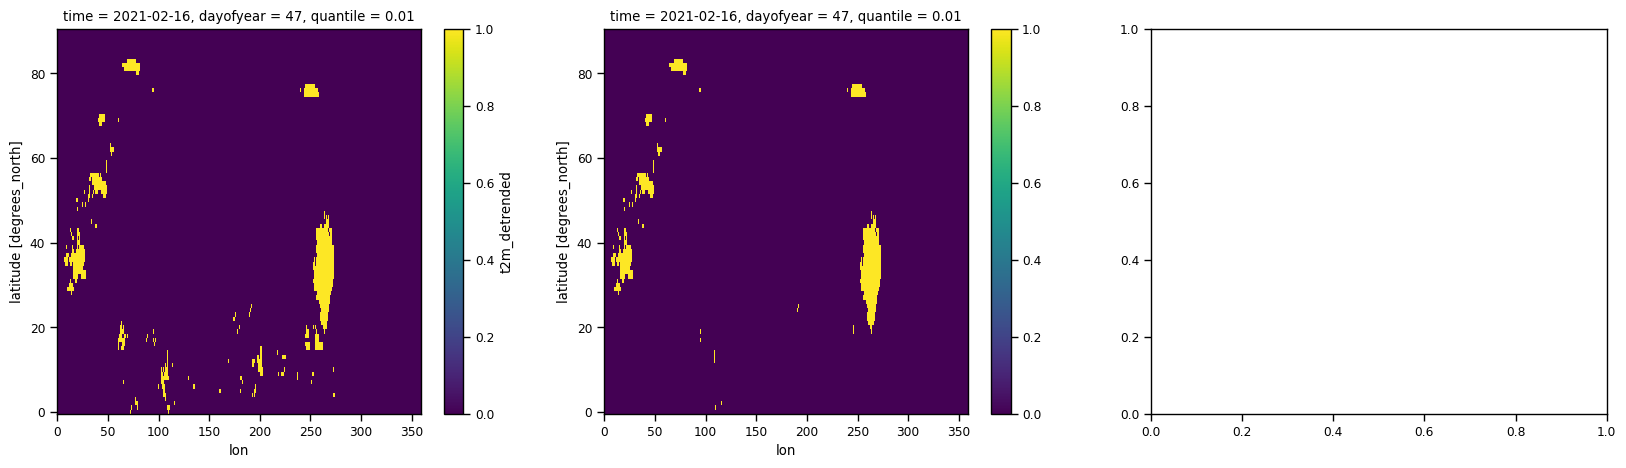

In [60]:
day_selected = "2021-02-16"
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
all_extreme_low_days.sel(time=day_selected).plot(ax=axes[0])
all_extreme_low_days_temp_limit.sel(time=day_selected).plot(ax=axes[1])
all_extreme_low_days_abs_limit.sel(time=day_selected).plot(ax=axes[2])

In [ ]:
all_extreme_low_days_abs_limit.sel(time=day_selected).plot()
plt.title('cold extremes')

In [ ]:
all_extreme_high_days_abs_limit.sel(time=day_selected).plot()
plt.title('hot extremes')

In [ ]:
extreme_day = kuang['jet_ocurrence1_jet_centre2'].sel(time=day_selected)
extreme_day = (extreme_day / extreme_day)
extreme_day.isel(time=0).plot.contourf()
all_extreme_low_days_abs_limit.sel(time=day_selected).plot.contour(cmap='blue', alpha=.3)
all_extreme_high_days_abs_limit.sel(time=day_selected).plot.contour(cmap='red', alpha=.3)

## WARNING: I have set a restriction that extreme low has to be below 0.C
This all needs tidying up

In [ ]:
all_extreme_low_days = all_extreme_low_days.to_dataset()
# all_extreme_high_days = all_extreme_high_days.to_dataset()

In [ ]:
all_extreme_low_days = all_extreme_low_days.reindex(lat=list(reversed(all_extreme_low_days.lat)))
# all_extreme_high_days = all_extreme_high_days.reindex(lat=list(reversed(all_extreme_high_days.lat)))

In [ ]:
def convert_to_minus_180_to_180(degrees_array):
    converted_array = np.where(degrees_array > 180, degrees_array - 360, degrees_array)
    return converted_array


def convert_to_0_to_360(degrees_array):
    converted_array = np.where(degrees_array < 0, degrees_array + 360, degrees_array)
    return converted_array

In [ ]:
all_extreme_low_days['lon'] = convert_to_minus_180_to_180(all_extreme_low_days['lon'].values)
all_extreme_low_days = all_extreme_low_days.sortby('lon')

In [ ]:
# all_extreme_high_days['lon'] = convert_to_minus_180_to_180(all_extreme_high_days['lon'].values)
# all_extreme_high_days = all_extreme_high_days.sortby('lon')

In [ ]:
lat_grid, lon_grid = np.meshgrid(all_extreme_low_days['lat'],all_extreme_low_days['lon'])
globe_land_mask = globe.is_land(lat_grid, lon_grid)
globe_land_mask.T

In [ ]:
all_extreme_low_days['t2m_detrended'] = all_extreme_low_days['t2m_detrended'].astype(int)

In [ ]:
# all_extreme_high_days['t2m'] = all_extreme_high_days['t2m'].astype(int)

In [ ]:
all_extreme_low_days_40to83 = all_extreme_low_days.sel(time=slice("1940", "1983"))
all_extreme_low_days_84to23 = all_extreme_low_days.sel(time=slice("1984", "2023"))

In [ ]:
all_extreme_low_days_84to23.sel(time="2021-02-16")['t2m_detrended'].plot()

In [ ]:
# all_extreme_high_days_40to83 = all_extreme_high_days.sel(time=slice("1940", "1983"))
# all_extreme_high_days_84to23 = all_extreme_high_days.sel(time=slice("1984", "2023"))

In [ ]:
%%time
# Takes 45 seconds
# all_extreme_low_days['t2m_landonly'] = all_extreme_low_days['t2m'].groupby('time').map(lambda x: x.where(globe_land_mask.T))

In [ ]:
# all_extreme_low_days_40to83.to_netcdf('../data/extreme_low_temp_detrend_anom_40to83_q01.nc')

In [ ]:
# all_extreme_low_days_84to23.to_netcdf('../data/extreme_low_temp_detrend_anom_84to23_q01.nc')